In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import DeviceStatsMonitor
from lightning.pytorch.callbacks import BasePredictionWriter

In [2]:
def convert_to_hourly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO HOURLY  #######################

    # Split the session into hourly intervals
    hourly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        # Generate hourly intervals
        hourly_intervals = pd.date_range(start=start.floor('h'), end=end.ceil('h'), freq='h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy


            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    # Create a new dataframe from the hourly intervals
    hourly_df = pd.DataFrame(hourly_rows)

    # Aggregate the hourly intervals
    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime(hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='h')

    # Reindex the hourly data to include all hours in the range
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    # Return the hourly data
    return hourly_df

def add_features(hourly_df):
  ####################### TIMED BASED FEATURES  #######################
  hourly_df['Day_of_Week'] = hourly_df.index.dayofweek

  # Add hour of the day
  hourly_df['Hour_of_Day'] = hourly_df.index.hour

  # Add month of the year
  hourly_df['Month_of_Year'] = hourly_df.index.month

  # Add year
  hourly_df['Year'] = hourly_df.index.year

  # Add day/night
  hourly_df['Day/Night'] = (hourly_df['Hour_of_Day']
                            >= 6) & (hourly_df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  hourly_df['IsHoliday'] = hourly_df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  hourly_df['Weekend'] = (hourly_df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################
  # Cos and sin transformations for cyclic features (hour of the day, day of the week, month of the year)

  hourly_df['HourSin'] = np.sin(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['HourCos'] = np.cos(2 * np.pi * hourly_df['Hour_of_Day'] / 24)
  hourly_df['DayOfWeekSin'] = np.sin(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['DayOfWeekCos'] = np.cos(2 * np.pi * hourly_df['Day_of_Week'] / 7)
  hourly_df['MonthOfYearSin'] = np.sin(2 * np.pi * hourly_df['Month_of_Year'] / 12)
  hourly_df['MonthOfYearCos'] = np.cos(2 * np.pi * hourly_df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  # 0 = Spring, 1 = Summer, 2 = Autumn, 3 = Winter
  month_to_season = {1: 4, 2: 4, 3: 0, 4: 0, 5: 0, 6: 1,
                     7: 1, 8: 1, 9: 2, 10: 2, 11: 2, 12: 3}
  hourly_df['Season'] = hourly_df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  # Lag features
  # 1h
  hourly_df['Energy_Consumption_1h'] = hourly_df['Energy_Consumption'].shift(1)

  # 6h
  hourly_df['Energy_Consumption_6h'] = hourly_df['Energy_Consumption'].shift(6)

  # 12h
  hourly_df['Energy_Consumption_12h'] = hourly_df['Energy_Consumption'].shift(12)

  # 24h
  hourly_df['Energy_Consumption_24h'] = hourly_df['Energy_Consumption'].shift(24)

  # 1 week
  hourly_df['Energy_Consumption_1w'] = hourly_df['Energy_Consumption'].shift(24*7)

  # Rolling average
  # 24h
  hourly_df['Energy_Consumption_rolling'] = hourly_df['Energy_Consumption'].rolling(window=24).mean()

  return hourly_df

def filter_data(start_date, end_date, data):
    ####################### FILTER DATASET  #######################
    data = data[(data.index >= start_date) & (data.index <= end_date)].copy()
    print(f"Data from {start_date} to {end_date} has been filtered.")
    #print(data.head())

    return data

def create_multivariate_dataset(data):
    rows = []

    for _, row in data.iterrows(): 
        row_data = dict(
            Energy_Consumption=row.Energy_Consumption,
            Session_Count=row.Session_Count,
            Day_of_week=row.Day_of_Week, 
            Hour_of_Day=row.Hour_of_Day, 
            Month_of_Year=row.Month_of_Year,
            Year = row.Year,
            Day_or_Night=row['Day/Night'],
            IsHoliday=row.IsHoliday, 
            Weekend=row.Weekend, 
            HourSin=row.HourSin, 
            HourCos=row.HourCos, 
            DayOfWeekSin=row.DayOfWeekSin, 
            DayOfWeekCos=row.DayOfWeekCos, 
            MonthOfYearSin=row.MonthOfYearSin, 
            MonthOfYearCos=row.MonthOfYearCos,
            Season=row.Season,
            Energy_Consumption_1h=row.Energy_Consumption_1h,
            Energy_Consumption_6h=row.Energy_Consumption_6h,
            Energy_Consumption_12h=row.Energy_Consumption_12h, 
            Energy_Consumption_24h=row.Energy_Consumption_24h, 
            Energy_Consumption_1w=row.Energy_Consumption_1w, 
            Energy_Consumption_rolling=row.Energy_Consumption_rolling
        )

    rows.append(row_data)

    return pd.DataFrame(rows)

features_cols = ["Session_Count", "Day_of_Week", "Hour_of_Day", "Month_of_Year", "Year", "Day/Night", "IsHolidays",
                 "Weekend", "HourSin", "HourCos", "DayOfWeekSin", "DayOfWeekCos", "MonthOfYearSin", "MonthOfYearCos", "Energy_Consumption_1h", 
                 "Energy_Consumption_6h", "Energy_Consumption_12h", "Energy_Consumption_24h", "Energy_Consumption_1w", "Energy_Consumption_rolling"]
target_col = "Energy_Consumption"

In [3]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()
    self.seq_len = seq_len

  def __len__(self):
    return len(self.X) - self.seq_len

  def __getitem__(self, index):
    return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [4]:
class ColoradoDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None

  def setup(self, stage: str):

    # Load and preprocess the data
    data = pd.read_csv(self.data_dir)
    data = convert_to_hourly(data)
    data = add_features(data)

    # One hot encoding for seasons 
    data = pd.get_dummies(data, columns=['Season'])

    # Filter the data
    df = filter_data('2018-01-01', '2020-12-31', data)

    # Split the data into features and target
    X = df.copy()
    y = X['Energy_Consumption'].shift(-1).ffill()

    # Drop the last row
    X = X.drop(columns=['Energy_Consumption'])

    # print("X shape:", X.shape)
    # print("y shape:", y.shape)

    # Split the data into training, validation, and test sets
    X_tv, self.X_test, y_tv, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_tv, y_tv, test_size=0.25, shuffle=False)

    # print("X_train shape:", self.X_train.shape)
    # print("X_val shape:", self.X_val.shape)
    # print("X_test shape:", self.X_test.shape)

    # print("y_train shape:", self.y_train.shape)
    # print("X_tv", X_tv)
    
    # Normalize the data
    preprocessing = self.scaler
    preprocessing.fit(self.X_train) # should only fit to training data

        
    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = self.y_train.values.reshape((-1, 1))
      self.X_val = preprocessing.transform(self.X_val)
      self.y_val = self.y_val.values.reshape((-1, 1))

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = self.y_test.values.reshape((-1, 1))

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return train_loader
  
  def val_dataloader(self):
    val_dataset = TimeSeriesDataset(self.X_val, self.y_val, seq_len=self.seq_len)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return val_loader

  def test_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    return test_loader

In [5]:
class LSTM(L.LightningModule):
  def __init__(self, input_size, hidden_size, num_layers, criterion, dropout, learning_rate):
    super().__init__()
    self.save_hyperparameters(ignore=['criterion'])
    self.dropout = dropout
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])  # Get the last time step
    print(f"Input shape: {x.shape}, Output shape: {out.shape}")
    return out

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y) 
    self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.criterion(y_hat, y)
    self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    test_loss = self.criterion(y_hat, y)
    self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.001)

In [6]:
class CustomWriter(BasePredictionWriter):
  def __init__(self, output_dir, write_interval):
    super().__init__(write_interval)
    self.output_dir = output_dir

  def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
    torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))
    # torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt")) # for batch indices if needed

In [7]:
params = dict(
  seq_len = 12,
  batch_size = 8,
  criterion = nn.MSELoss(),
  max_epochs = 1000,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 1, # can be 0.2 if more output layers are present
  learning_rate = 0.001,
  num_workers = 7, # only work in .py for me
  is_persistent = False, # only work in .py for me
  scaler = MinMaxScaler()
)

In [8]:
model = LSTM(input_size=len(features_cols), hidden_size=params['hidden_size'], num_layers=params['num_layers'], criterion=params['criterion'], dropout=params['dropout'], learning_rate=params['learning_rate'])
colmod = ColoradoDataModule(data_dir='./Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv',  scaler=params['scaler'], seq_len=params['seq_len'], batch_size=params['batch_size'], num_workers=params['num_workers'], is_persistent=params['is_persistent'])
pred_writer = CustomWriter(output_dir="Models", write_interval="epoch")

Bottleneck finding

In [ ]:
trainer_bottleneck = L.Trainer(max_epochs=50, profiler="simple")
trainer_bottleneck.fit(model, colmod)
trainer_bottleneck.test(model, colmod)
trainer_bottleneck.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 48.8 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
48.9 K    Trainable params
0         Non-trainable params
48.9 K    Total params
0.196     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Data from 2018-01-01 to 2020-12-31 has been filtered.
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Performance Evaluation (Measures accelerator usage)

In [26]:
trainer_eval = L.Trainer(max_epochs=50, callbacks=[DeviceStatsMonitor()])
trainer_eval.fit(model, colmod)
trainer_eval.test(model, colmod)
trainer_eval.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 72/72 [00:00<00:00, 93.08it/s, v_num=1, train_loss_step=0.0156, val_loss_step=6.310, val_loss_epoch=27.70, train_loss_epoch=35.60]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 72/72 [00:00<00:00, 92.05it/s, v_num=1, train_loss_step=0.0156, val_loss_step=6.310, val_loss_epoch=27.70, train_loss_epoch=35.60]


/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 104.99it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        20.882078170776367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 232.48it/s]


Fast Development run (runs n batches of training, validation and test to check for bugs)

In [27]:
trainer_dev = L.Trainer(max_epochs=params['max_epochs'], default_root_dir='Models', callbacks=[EarlyStopping(monitor="val_loss", mode="min")], fast_dev_run=10)
trainer_dev.fit(model, colmod)
trainer_dev.test(model, colmod)
trainer_dev.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 10 batch(es). Logging and checkpointing is suppressed.

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to 

Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 57.72it/s, train_loss_step=35.30, val_loss_step=23.20, val_loss_epoch=26.30, train_loss_epoch=19.80]

`Trainer.fit` stopped: `max_steps=10` reached.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 56.94it/s, train_loss_step=35.30, val_loss_step=23.20, val_loss_epoch=26.30, train_loss_epoch=19.80]

/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 176.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        28.652475357055664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 152.86it/s]


## Runs

Standard Run

In [28]:
trainer = L.Trainer(max_epochs=params['max_epochs'], callbacks=[EarlyStopping(
    monitor="val_loss", mode="min"), pred_writer], default_root_dir='Models', accelerator="mps", devices=1)
trainer.fit(model, colmod)
trainer.test(model, colmod)
trainer.predict(model, colmod, return_predictions=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | lstm      | LSTM    | 41.2 K | train
2 | fc        | Linear  | 101    | train
----------------------------------------------
41.3 K    Trainable params
0         Non-trainable params
41.3 K    Total params
0.165     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 31: 100%|██████████| 72/72 [00:00<00:00, 98.53it/s, v_num=0, train_loss_step=0.763, val_loss_step=9.160, val_loss_epoch=25.40, train_loss_epoch=30.20]   


/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 96.26it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch        20.723068237304688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/opt/homebrew/Caskroom/miniconda/base/envs/p10/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 23/23 [00:00<00:00, 195.86it/s]


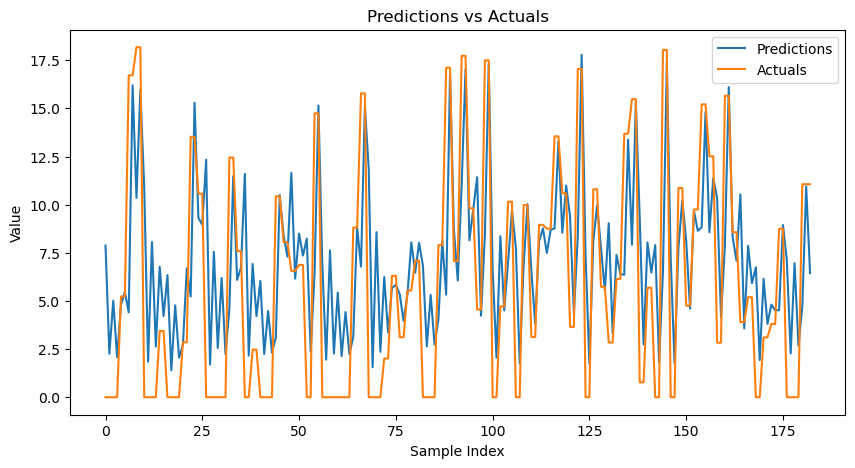

In [29]:
predictions = torch.load('Models/predictions_0.pt')

actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

# Flatten the predictions and actuals
predictions_flat = [item.item() for sublist in predictions for item in sublist]
actuals_flat = [item for sublist in actuals for item in sublist]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(predictions_flat, label='Predictions')
plt.plot(actuals_flat, label='Actuals')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predictions vs Actuals')
plt.legend()
plt.show()

In [30]:
%reload_ext tensorboard
%tensorboard --logdir=Models/lightning_logs/

Reusing TensorBoard on port 6006 (pid 45194), started 0:03:53 ago. (Use '!kill 45194' to kill it.)

## MPS test

In [19]:
def check_mps():
    if torch.backends.mps.is_available():
        print("MPS is available")
    else:
        print("MPS is not available")

    if torch.backends.mps.is_built():
        print("MPS is built")
    else:
        print("MPS is not built")

    if torch.backends.mps.is_macos13_or_newer():
        print("MPS is macOS 13 or newer")
    else:
        print("MPS is not macOS 13 or newer")

check_mps()

MPS is available
MPS is built
MPS is macOS 13 or newer
